# **AlexNet challenge (PyTorch)**
_Felipe Andres Castillo_




In [ ]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible:", torch.cuda.get_device_name(0))
    torch.cuda.synchronize() # Sincronización para medir tiempo de ejecución en GPU
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

GPU disponible: Tesla T4


# Modelo 1: AlexNet modificado
Se utilizan las imágenes con su tamaño original (32x32); esto implica modificar los inputs y outputs de algunas capas del modelo original.

## 1. Los datos

El conjunto de datos CIFAR-10 consta de 60 000 imágenes en color de 32 x 32 en 10 clases, con 6000 imágenes por clase. Hay 50 000 imágenes de entrenamiento y 10 000 imágenes de prueba.

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10 000 imágenes. El lote de prueba contiene exactamente 1000 imágenes seleccionadas aleatoriamente de cada clase. Los lotes de entrenamiento contienen las imágenes restantes en orden aleatorio, pero algunos lotes de entrenamiento pueden contener más imágenes de una clase que de otra. Entre ellos, los lotes de entrenamiento contienen exactamente 5000 imágenes de cada clase.

In [ ]:
# Obtención de los conjuntos de datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root = "./data/CIFAR",
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.CIFAR10(
    root = "./data/CIFAR",
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Extracting ./data/CIFAR/cifar-10-python.tar.gz to ./data/CIFAR
Files already downloaded and verified


In [ ]:
# Las diez diferentes clases del dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data Loaders
batchSize = 64
train_loader = DataLoader(train_dataset, batch_size = batchSize, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batchSize, shuffle = False, num_workers = 2)

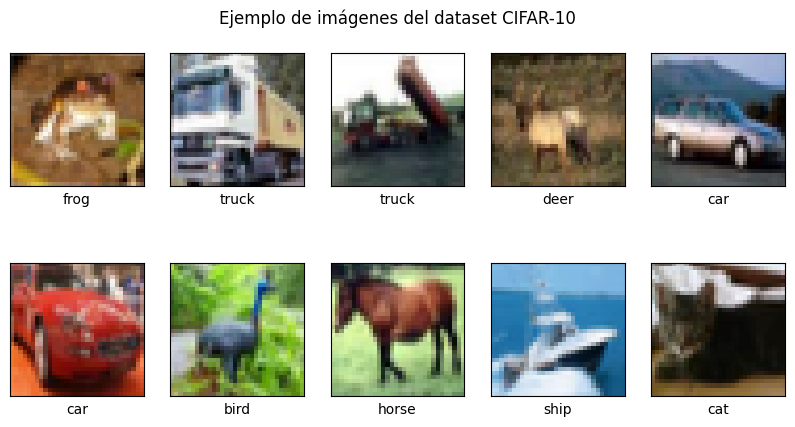

In [ ]:
# Ejemplo de las imagenes del dataset
plt.figure(figsize=(10,5))
plt.title("Ejemplo de imágenes del dataset CIFAR-10")
plt.axis('off')
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = train_dataset[i]
    # Se convierte el tensor a numpy y se reordenan las dimensiones de (C, H, W) -> (H, W, C)
    image = image.numpy().transpose(1, 2, 0)
    # Se reescala si la imagen tiene valores fuera del rango [0,1]
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image)
    plt.xlabel(classes[label])
plt.show()

## 2. El modelo

El modelo original de AlexNet contempla que las imágenes utilizadas tienen dimensiones de 224x224. En este caso al ser imágenes mucho más pequeñas, y por consiguiente, para evitar errores en el procesamiento en cada capa, se elimina el stride = 4 en la primera capa convolucional. También se modifican los inputs y outputs de las capas densas para que coincidan con la salida de la ultima capa convolucional y su posterior _aplanamiento_.

In [ ]:
# Creación del modelo AlexNet para imagenes de 32x32
class AlexNet_v1(nn.Module):
  def __init__(self):
    super(AlexNet_v1, self).__init__()
    self.cn1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, padding=2)
    self.cn2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
    self.cn3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
    self.cn4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3,padding=1)
    self.cn5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=10)
    self.dp = nn.Dropout(p=0.5)
  def forward(self, x):
    x = F.relu(self.cn1(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = F.relu(self.cn2(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = F.relu(self.cn3(x))
    x = F.relu(self.cn4(x))
    x = F.relu(self.cn5(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = self.dp(x)
    x = F.relu(self.fc2(x))
    x = self.dp(x)
    x = self.fc3(x)
    return x

In [ ]:
# Se carga el modelo en la GPU (si es el caso)
model_1 = AlexNet_v1().to(device)
# Función de perdida
criterion = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
# Número totoal de parámetros entrenables del modelo
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("AlexNet model params = ", count_params(model_1))

AlexNet model params =  4539786


## 3. Entrenamiento

In [ ]:
# Función de entrenamiento
def train(model, train_loader, optimizer, criterion, epoch, device):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device) # Envía los datos a la GPU (si es el caso)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                     batch_idx * len(data),
                                                                     len(train_loader.dataset),
                                                                     100. * batch_idx / len(train_loader),
                                                                     loss.item()))

In [ ]:
# Función de evaluación, devuelve perdida promedio y precisión
def test(model, test_loader, class_acc):
  model.eval()
  test_loss = 0 # Inicializa la pérdida total
  correct = 0  # Inicializa el contador de aciertos

  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  with torch.no_grad(): # Desactiva el cálculo de gradientes
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item() # Calcula pérdida y la acumula
      pred = output.argmax(dim=1, keepdim=True) # Se obtiene la clase con mayor probabilidad
      correct += pred.eq(target.view_as(pred)).sum().item() # Cuenta y suma los aciertos

      # (Si es el caso) se calcula el accuracy por clase
      if class_acc:
        c = pred.eq(target.view_as(pred)).squeeze()
        for i in range(len(target)):
          label = target[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1

  test_loss /= len(test_loader) # Se calcula la pérdida promedio [len(test_loader) es el número de batches; no es el número de elementos por batch]
  accuracy = correct / len(test_loader.dataset) # Se calcula la precisión [len(test_loader.dataset) es el número total de elementos]
  print("\n Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(test_loss,
                                                                               correct,
                                                                               len(test_loader.dataset),
                                                                               100. * accuracy))
  if class_acc:
    for i in range(10):
      print(f"Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %")

  return test_loss, accuracy

In [ ]:
# Ciclo de entrenamiento AlexNet_v1
num_epochs = 15
acc_history = []
loss_history = []

start_time = timeit.default_timer()
for epoch in range(1,num_epochs+1):
  train(model_1, train_loader, optimizer, criterion, epoch, device)
  loss, acc = test(model_1, train_loader, False)
  acc_history.append(acc)
  loss_history.append(loss)
end_time = timeit.default_timer()
print("Fin del entrenamiento")
traintime_v1 = end_time - start_time
print(f"Tiempo total de entrenamiento: {traintime_v1:.2f} segundos")

Train Epoch 1: [0/50000 (0%)]	Loss: 2.301775
Train Epoch 1: [6400/50000 (13%)]	Loss: 2.039191
Train Epoch 1: [12800/50000 (26%)]	Loss: 2.079159
Train Epoch 1: [19200/50000 (38%)]	Loss: 2.034410
Train Epoch 1: [25600/50000 (51%)]	Loss: 1.962159
Train Epoch 1: [32000/50000 (64%)]	Loss: 1.851792
Train Epoch 1: [38400/50000 (77%)]	Loss: 1.636919
Train Epoch 1: [44800/50000 (90%)]	Loss: 1.560817

 Average loss: 1.6571, Accuracy: 17848/50000 (36%)

Train Epoch 2: [0/50000 (0%)]	Loss: 1.706095
Train Epoch 2: [6400/50000 (13%)]	Loss: 2.019486
Train Epoch 2: [12800/50000 (26%)]	Loss: 1.659666
Train Epoch 2: [19200/50000 (38%)]	Loss: 1.693980
Train Epoch 2: [25600/50000 (51%)]	Loss: 1.486063
Train Epoch 2: [32000/50000 (64%)]	Loss: 1.599810
Train Epoch 2: [38400/50000 (77%)]	Loss: 1.566181
Train Epoch 2: [44800/50000 (90%)]	Loss: 1.471064

 Average loss: 1.4439, Accuracy: 23078/50000 (46%)

Train Epoch 3: [0/50000 (0%)]	Loss: 1.442458
Train Epoch 3: [6400/50000 (13%)]	Loss: 1.502554
Train Epoch 

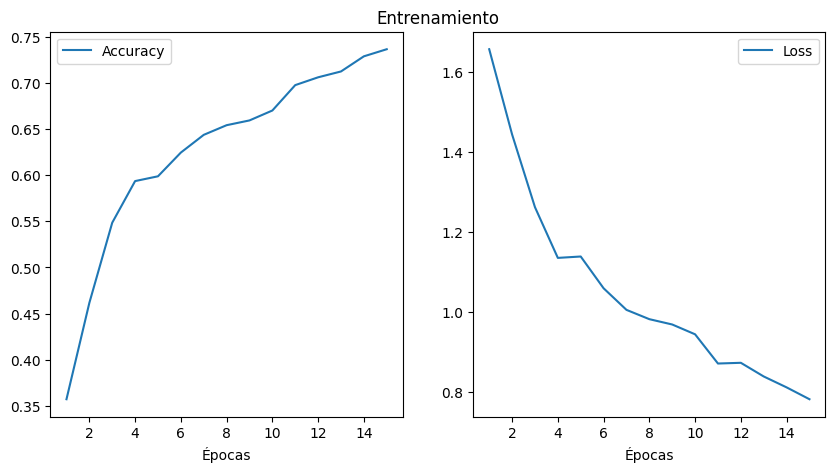

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Entrenamiento modelo 1: AlexNet modificado")
plt.axis('off')
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs+1), acc_history, label="Accuracy")
plt.xlabel("Épocas")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1,num_epochs+1), loss_history, label="Loss")
plt.xlabel("Épocas")
plt.legend()
plt.show()

In [ ]:
# Se guarda el modelo (pesos)
modelPath = "./data/CIFAR/"
modelName = modelPath + "AlexNet_v1_Cifar10.pth"
torch.save(model_1.state_dict(), modelName)

## 4. Evaluación

In [ ]:
# Si se ha guardado el modelo, aquí se carga
# modelPath = "./data/CIFAR/"
# modelName = modelPath + "AlexNet_v1_Cifar10.pth"
# model_1 = AlexNet()
# modelo_1.load_state_dict(torch.load(modelName))

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T1, acc_T1 = test(model_1, test_loader, True)

Evaluación del modelo en el conjunto de prueba

 Average loss: 1.0529, Accuracy: 6370/10000 (64%)

Accuracy of plane : 68.60 %
Accuracy of car   : 76.80 %
Accuracy of bird  : 46.70 %
Accuracy of cat   : 41.40 %
Accuracy of deer  : 69.40 %
Accuracy of dog   : 38.30 %
Accuracy of frog  : 76.20 %
Accuracy of horse : 67.70 %
Accuracy of ship  : 75.80 %
Accuracy of truck : 76.10 %


# Modelo 2: AlexNet from scratch
Reescanlando el tamaño de las imágenes a 224x224 y definiendo el modelo con los parámetros originales en cada capa.

## 1. Los datos

In [ ]:
# Obtención de los conjuntos de datos, aplicando el reescalamiento
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root = "./data/CIFAR",
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.CIFAR10(
    root = "./data/CIFAR",
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data Loaders
batchSize = 64
train_loader = DataLoader(train_dataset, batch_size = batchSize, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batchSize, shuffle = False, num_workers = 2)

## 2. El modelo

In [ ]:
# Creación del modelo AlexNet para imagenes de 224x224
class AlexNet_v2(nn.Module):
  def __init__(self):
    super(AlexNet_v2, self).__init__()
    self.cn1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, padding=2, stride=4)
    self.cn2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
    self.cn3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
    self.cn4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3,padding=1)
    self.cn5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(in_features=9216, out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc3 = nn.Linear(in_features=4096, out_features=10)
    self.dp = nn.Dropout(p=0.5)
  def forward(self, x):
    x = F.relu(self.cn1(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = F.relu(self.cn2(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = F.relu(self.cn3(x))
    x = F.relu(self.cn4(x))
    x = F.relu(self.cn5(x))
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = self.dp(x)
    x = F.relu(self.fc2(x))
    x = self.dp(x)
    x = self.fc3(x)
    return x

In [ ]:
# Se carga el modelo en la GPU
model_2 = AlexNet_v2().to(device)
# Función de perdida
criterion = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [ ]:
print("AlexNet model params = ", count_params(model_2))

AlexNet model params =  58322314


## 3. Entrenamiento

In [ ]:
# Ciclo de entrenamiento AlexNet_v2
num_epochs = 15
acc_history = []
loss_history = []

start_time = timeit.default_timer()
for epoch in range(1,num_epochs+1):
  train(model_2, train_loader, optimizer, criterion, epoch, device)
  loss, acc = test(model_2, train_loader, False)
  acc_history.append(acc)
  loss_history.append(loss)
end_time = timeit.default_timer()
print("Fin del entrenamiento")
traintime_v2 = end_time - start_time
print(f"Tiempo total de entrenamiento: {traintime_v2:.2f} segundos")

Train Epoch 1: [0/50000 (0%)]	Loss: 2.302480
Train Epoch 1: [6400/50000 (13%)]	Loss: 1.962781
Train Epoch 1: [12800/50000 (26%)]	Loss: 1.830029
Train Epoch 1: [19200/50000 (38%)]	Loss: 1.761237
Train Epoch 1: [25600/50000 (51%)]	Loss: 1.536608
Train Epoch 1: [32000/50000 (64%)]	Loss: 1.605390
Train Epoch 1: [38400/50000 (77%)]	Loss: 1.679134
Train Epoch 1: [44800/50000 (90%)]	Loss: 1.253224

 Average loss: 1.3568, Accuracy: 25503/50000 (51%)

Train Epoch 2: [0/50000 (0%)]	Loss: 1.528077
Train Epoch 2: [6400/50000 (13%)]	Loss: 1.542971
Train Epoch 2: [12800/50000 (26%)]	Loss: 1.497714
Train Epoch 2: [19200/50000 (38%)]	Loss: 1.425901
Train Epoch 2: [25600/50000 (51%)]	Loss: 1.165198
Train Epoch 2: [32000/50000 (64%)]	Loss: 1.491337
Train Epoch 2: [38400/50000 (77%)]	Loss: 1.343976
Train Epoch 2: [44800/50000 (90%)]	Loss: 1.139500

 Average loss: 1.1588, Accuracy: 29411/50000 (59%)

Train Epoch 3: [0/50000 (0%)]	Loss: 1.063707
Train Epoch 3: [6400/50000 (13%)]	Loss: 1.184980
Train Epoch 

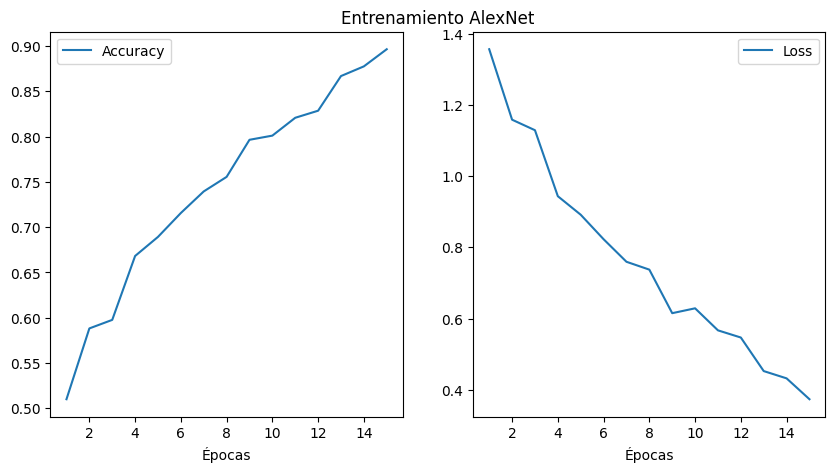

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Entrenamiento AlexNet")
plt.axis('off')
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs+1), acc_history, label="Accuracy")
plt.xlabel("Épocas")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1,num_epochs+1), loss_history, label="Loss")
plt.xlabel("Épocas")
plt.legend()
plt.show()

In [ ]:
# Se guarda el modelo
modelPath = "./data/CIFAR/"
modelName = modelPath + "AlexNet_v2_Cifar10.pth"
torch.save(model_2.state_dict(), modelName)

## 4. Evaluación

In [ ]:
# Si se ha guardado el modelo, aquí se carga
# modelPath = "./data/CIFAR/"
# modelName = modelPath + "AlexNet_v2_Cifar10.pth"
# model_2 = AlexNet()
# modelo_2.load_state_dict(torch.load(modelName))

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T2, acc_T2 = test(model_2, test_loader, True)

Evaluación del modelo en el conjunto de prueba

 Average loss: 1.0136, Accuracy: 6661/10000 (67%)

Accuracy of plane : 70.30 %
Accuracy of car   : 77.50 %
Accuracy of bird  : 52.50 %
Accuracy of cat   : 45.10 %
Accuracy of deer  : 63.00 %
Accuracy of dog   : 50.40 %
Accuracy of frog  : 79.70 %
Accuracy of horse : 74.70 %
Accuracy of ship  : 79.10 %
Accuracy of truck : 73.80 %


# Modelo 3: AlexNet pre-entrenado
Se usa el modelo incluido en la biblioteca torchvision.models directamente, sin ningún entrenamiento posterior.

In [ ]:
# Se carga el modelo pre-entrenado
model = models.alexnet(weights=True)
# model.classifier es la parte fully connected de AlexNet
# el layer número 6 es el ultimo layer del modelo: Linear(in_features=4096, out_features=1000)
num_features = model.classifier[6].in_features
# Se cambia esta ultima capa por una donde los inputs sean los mismos, pero los outputs cambien a 10
model.classifier[6] = nn.Linear(num_features, 10)
# Se manda el modelo a la GPU
model = model.to(device)

# Función de perdida
criterion = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T4, acc_T4 = test(model, test_loader, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Modelo 3: AlexNet pre-entrenado 2.0
Se usa el modelo incluido en la biblioteca torchvision.models

## 1. Los datos

En este caso, se utilizan los mismos datos y data loaders del modelo anterior

## 2. El modelo

In [ ]:
# Se carga el modelo pre-entrenado
model_3 = models.alexnet(weights=True)
# model.classifier es la parte fully connected de AlexNet
# el layer número 6 es el ultimo layer del modelo: Linear(in_features=4096, out_features=1000)
num_features = model_3.classifier[6].in_features
# Se cambia esta ultima capa por una donde los inputs sean los mismos, pero los outputs cambien a 10
model_3.classifier[6] = nn.Linear(num_features, 10)
# Se manda el modelo a la GPU
model_3 = model_3.to(device)

# Función de perdida
criterion = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
# Número total de parámetros entrenables del modelo
print("AlexNet model params = ", count_params(model_3))

AlexNet model params =  57044810


## 3. Entrenamiento

In [ ]:
# Ciclo de entrenamiento AlexNet_v3
num_epochs = 15
acc_history = []
loss_history = []

start_time = timeit.default_timer()
for epoch in range(1,num_epochs+1):
  train(model_3, train_loader, optimizer, criterion, epoch, device)
  loss, acc = test(model_3, train_loader, False)
  acc_history.append(acc)
  loss_history.append(loss)
end_time = timeit.default_timer()
print("Fin del entrenamiento")
traintime_v3 = end_time - start_time
print(f"Tiempo total de entrenamiento: {traintime_v3:.2f} segundos")

Train Epoch 1: [0/50000 (0%)]	Loss: 2.484256
Train Epoch 1: [6400/50000 (13%)]	Loss: 2.001378
Train Epoch 1: [12800/50000 (26%)]	Loss: 1.988543
Train Epoch 1: [19200/50000 (38%)]	Loss: 2.006165
Train Epoch 1: [25600/50000 (51%)]	Loss: 1.672419
Train Epoch 1: [32000/50000 (64%)]	Loss: 1.870311
Train Epoch 1: [38400/50000 (77%)]	Loss: 1.715744
Train Epoch 1: [44800/50000 (90%)]	Loss: 1.828236

 Average loss: 1.4348, Accuracy: 23677/50000 (47%)

Train Epoch 2: [0/50000 (0%)]	Loss: 1.291413
Train Epoch 2: [6400/50000 (13%)]	Loss: 1.343254
Train Epoch 2: [12800/50000 (26%)]	Loss: 1.223958
Train Epoch 2: [19200/50000 (38%)]	Loss: 1.337153
Train Epoch 2: [25600/50000 (51%)]	Loss: 1.259437
Train Epoch 2: [32000/50000 (64%)]	Loss: 1.423819
Train Epoch 2: [38400/50000 (77%)]	Loss: 1.365988
Train Epoch 2: [44800/50000 (90%)]	Loss: 0.986643

 Average loss: 1.1136, Accuracy: 30212/50000 (60%)

Train Epoch 3: [0/50000 (0%)]	Loss: 1.196145
Train Epoch 3: [6400/50000 (13%)]	Loss: 1.134972
Train Epoch 

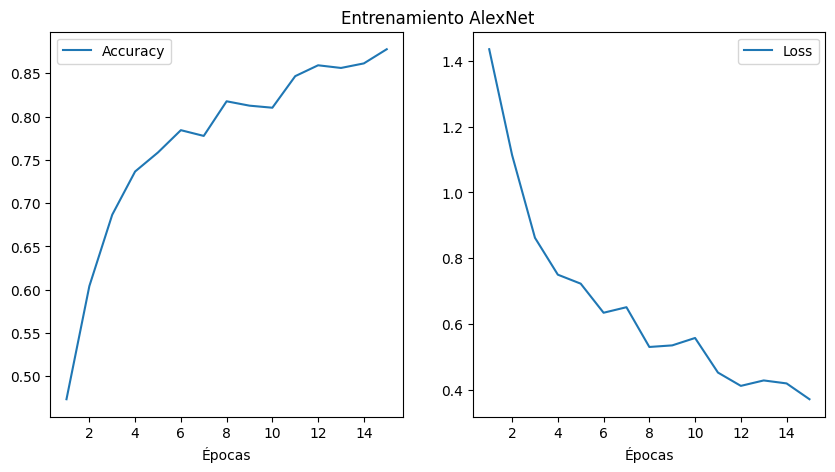

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Entrenamiento AlexNet")
plt.axis('off')
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs+1), acc_history, label="Accuracy")
plt.xlabel("Épocas")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1,num_epochs+1), loss_history, label="Loss")
plt.xlabel("Épocas")
plt.legend()
plt.show()

In [ ]:
# Se guarda el modelo
modelPath = "./data/CIFAR/"
modelName = modelPath + "AlexNet_v3_Cifar10.pth"
torch.save(model_3.state_dict(), modelName)

## 4. Evaluación

In [ ]:
# Si se ha guardado el modelo, aquí se carga
# modelPath = "./data/CIFAR/"
# modelName = modelPath + "AlexNet_v3_Cifar10.pth"
# model_3 = AlexNet()
# modelo_3.load_state_dict(torch.load(modelName))

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T3, acc_T3 = test(model_3, test_loader, True)

Evaluación del modelo en el conjunto de prueba

 Average loss: 0.6898, Accuracy: 7809/10000 (78%)

Accuracy of plane : 78.00 %
Accuracy of car   : 81.90 %
Accuracy of bird  : 63.90 %
Accuracy of cat   : 66.60 %
Accuracy of deer  : 77.40 %
Accuracy of dog   : 72.00 %
Accuracy of frog  : 80.90 %
Accuracy of horse : 79.70 %
Accuracy of ship  : 90.60 %
Accuracy of truck : 89.90 %


# Resumen

In [ ]:
import pandas as pd

# Se crea un dataframe con los resultados de los modelos
results = pd.DataFrame({
    "Modelo": ["AlexNet (32x32)", "AlexNet (224x224)", "AlexNet (pre-entrenado)"],
    "Tiempo de entrenamiento (segundos)": [traintime_v1, traintime_v2, traintime_v3],
    "Accuracy test": [acc_T1, acc_T2, acc_T3],
    "Loss test": [loss_T1, loss_T2, loss_T3]
})

results

,Modelo,Tiempo de entrenamiento (segundos),Accuracy test,Loss test
0,AlexNet (32x32),471.113666,0.6370,1.052892
1,AlexNet (224x224),2810.178915,0.6661,1.013621
2,AlexNet (pre-entrenado),2651.969516,0.7809,0.689839


Los tres modelos fueron entrenados con las mismas condiciones: misma función de perdida y optimización, mismo número de elementos por batch y mismo número de epocas. Como resultado, el modelo pre-entrenado fue el que tuvo una mayor precisión y menor perdida, aunque no fue el que menor tiempo de entrenamiento tuvo, esto dado el número de parámetros involucrados en el entrenamiento.

El modelo AlexNet (224x224), que era una replica del modelo original sin pre-entrenamiento, tuvo un tiempo de entrenamiento un poco mayor a este, pero con resultados más deficientes. Esto revela que resulta más conveniente usar el modelo directamente de la biblioteca torchvision.models.

Mientras que el modelo de AlexNet modificado para usarse directamente con las imagenes de 32x32 tuvo los valores más bajos de precisión y perdida, estos no son muy diferentes al modelo sin pre-entrenamiento, además de que el tiempo de entrenamiento fue más corto.  